<a href="https://colab.research.google.com/github/VIGNESHMADAN/1BM22AI151_AGA_LAB/blob/main/CHEST_XRAY_DENOISING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib tensorflow


In [ ]:
import numpy as np
import cv2
import os

def load_images_from_folder(folder, img_size=(128, 128), max_images=200):
    images = []
    count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                count += 1
                if count >= max_images:
                    break
        if count >= max_images:
            break
    return np.array(images)

# Provide your local/Colab folder path
folder_path = '/content/drive/MyDrive/chest'  # adjust if needed
images = load_images_from_folder(folder_path, max_images=200)
print(f"Loaded {images.shape[0]} images, shape: {images.shape}")


Loaded 29 images, shape: (29, 128, 128)


In [ ]:
def add_noise(images, mean=0, std=0.1):
    noisy = images + np.random.normal(mean, std, images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

noisy_images = add_noise(images)


In [ ]:
# Expand dimensions to (batch, height, width, channels)
images = np.expand_dims(images, axis=-1)
noisy_images = np.expand_dims(noisy_images, axis=-1)

# Train-test split (80-20)
split = int(0.8 * len(images))
x_train, x_test = noisy_images[:split], noisy_images[split:]
y_train, y_test = images[:split], images[split:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(x_train, y_train,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(x_test, y_test))


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.0058 - val_loss: 0.0073
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.0057 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


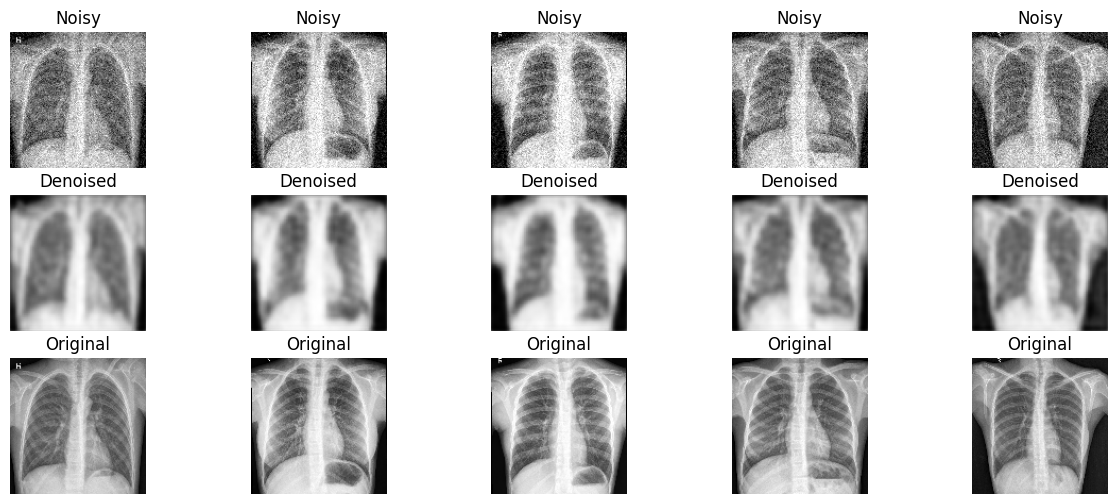

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 5  # number of samples to show
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original clean
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.show()
